In [28]:
#!pip install astropy photutils
#!pip install astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.visualization import simple_norm
from photutils.background import Background2D, MedianBackground
from scipy.spatial import KDTree

# Define a function to calculate the star flux
def calculateStarFlux(data):
    # Define the box size over which the background is estimated
    box_size = (50, 50)  # This should be adjusted based on your image's characteristics

    # Create a background 2D object with a median filter background estimator
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, box_size, filter_size=(3, 3), bkg_estimator=bkg_estimator)

    # The background noise (sigma) map
    sigma_map = bkg.background_rms

    # An overall estimate of the background noise can be the median of this map
    bkg_sigma = np.median(sigma_map)

    print(f'Estimated background sigma: {bkg_sigma}')

    # Initialize a star finder
    daofind = DAOStarFinder(fwhm=15.0, threshold=5*bkg_sigma)

    # Find stars in the image
    stars = daofind(data)

    # Perform aperture photometry
    positions = np.transpose((stars['xcentroid'], stars['ycentroid']))
    apertures = CircularAperture(positions, r=3)
    phot_table_sub = aperture_photometry(data - bkg.background, apertures)  # Subtract background from image data first

    return phot_table_sub, apertures, positions, stars

# Function to display stars on the image
def showStars(data, stars, apertures, band):
    # Normalize the image for better visualization
    norm = simple_norm(data, 'sqrt', percent=99)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Greys', norm=norm)
    plt.colorbar()

    # Overlay detected stars
    plt.scatter(stars['xcentroid'], stars['ycentroid'], s=20, edgecolor='red', facecolor='none', label='Detected stars')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.legend()
    plt.title(f'{band} band image with detected stars')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.show()

# Function to calculate the fluxes of a range of files
def calculateFluxes(files):
    image_data = {}
    for i in range(len(files)):
        filename = files[i]
        print(filename)
        band = filename.split('.')[0].split('_')[-1]
        print(f'Processing file {band}')

        data = fits.getdata(filename)
        phot_table_sub, apertures, positions, stars = calculateStarFlux(data)

        image_data[band] = {'phot_table_sub': phot_table_sub, 'apertures': apertures,
                            'positions': positions, 'stars': stars, 'data': data}
    return image_data

# Function to display stars for a single image with their photometric circles
def showStars(data, stars, apertures, band):
    # Normalize the image for better visualization
    norm = simple_norm(data, 'sqrt', percent=99)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Greys', norm=norm)
    plt.colorbar()

    # Overlay detected stars
    plt.scatter(stars['xcentroid'], stars['ycentroid'], s=20, edgecolor='red', facecolor='none', label='Detected stars')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.legend()
    plt.title(f'{band} band image with detected stars')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.show()

# Function to display all the images in the dictionary including their detected stars
def display_images_fluxes(image_data):
    for band in image_data.keys():
        print(band)
        showStars(image_data[band]['data'], image_data[band]['stars'], image_data[band]['apertures'], band)
        print(image_data[band]['phot_table_sub'])

In [30]:
def distances_from_center(image_data):
    for band in image_data.keys():
        # Find the center of the image
        x_center = int(image_data[band]['data'].shape[1]/2)
        y_center = int(image_data[band]['data'].shape[0]/2)
        # Find the distance of each star from the center
        image_data[band]['distance'] = np.sqrt((image_data[band]['stars']['xcentroid'] - x_center)**2 +
                                                (image_data[band]['stars']['ycentroid'] - y_center)**2)
        print(image_data[band]['distance'])
    return image_data

def match_indices_between_images(positions1, positions2):
    # Build KDTree for one of the sets of positions
    tree = KDTree(positions1)

    # Query the tree for nearest neighbors in the second set of positions
    d, indices = tree.query(positions2, distance_upper_bound=50.0)  # adjust the upper bound as necessary

    # Filter out non-matches (where distance is infinity or beyond a threshold)
    matches = indices < len(positions1)
    matched_indices1 = indices[matches]
    matched_indices2 = np.arange(len(positions2))[matches]

    # Now matched_indices1 and matched_indices2 give you indices in phot_table1 and phot_table2 that match
    return matched_indices1, matched_indices2

In [31]:
def find_median_offset(positions1, positions2, matched_indices1, matched_indices2, display=False):
    diffs = []
    for kk in range(len(matched_indices1)):
        ii = matched_indices1[kk]
        jj = matched_indices2[kk]
        diffs.append(positions1[ii] - positions2[jj])

    diffs = np.array(diffs)
    median_diff = np.median(diffs, axis=0)
    std_diff = np.std(diffs, axis=0)

    if display:
        # Set up two side by side plots in matplotlib
        fig, ax = plt.subplots(1, 2, figsize=(8, 3))
        ax[0].hist(diffs[:,0], bins=20)
        ax[0].set_xlabel('X Position Difference')
        ax[1].hist(diffs[:,1], bins=20)
        ax[1].set_xlabel('Y Position Difference')
        plt.show()

    return median_diff, std_diff, diffs

def match_the_stars(band1, band2, image_data, display=False):
    phot_table1 = image_data[band1]['phot_table_sub']
    phot_table2 = image_data[band2]['phot_table_sub']

    positions1 = np.array([phot_table1['xcenter'], phot_table1['ycenter']]).transpose()
    positions2 = np.array([phot_table2['xcenter'], phot_table2['ycenter']]).transpose()

    matched_indices1, matched_indices2 = match_indices_between_images(positions1, positions2)

    median_diff, std_diff, diffs = find_median_offset(positions1, positions2, matched_indices1, matched_indices2, display)

    # Adjust the positions by the median offset
    positions2_updated = positions2 + median_diff

    # Repeat the matching process with updated positions
    matched_indices1, matched_indices2 = match_indices_between_images(positions1, positions2_updated)

    return median_diff, std_diff, diffs, matched_indices1, matched_indices2

def create_final_star_list(image_data, band1, matched_indices1, matched_indices2, median_diff, std_diff, diffs):
    # find the image size
    image_size = image_data[band1]['data'].shape
    # find the image diagonal
    max_distance = np.sqrt(image_size[0]**2 + image_size[1]**2)/2
    # create two new set of indices where the difference is no more than s stds from the median
    s = 2
    new_matched_indices1 = []
    new_matched_indices2 = []
    print(len(matched_indices1), len(matched_indices2))
    for kk in range(len(matched_indices1)):
        ii = matched_indices1[kk]
        jj = matched_indices2[kk]
        # find the distance of the star from the center in image 1
        dist1 = image_data[band1]['distance'][ii]
        # find the distance of the star from the center in image 1

        if np.all(np.abs(diffs[kk] - median_diff) < s*std_diff) and dist1 < max_distance*0.7:
            new_matched_indices1.append(ii)
            new_matched_indices2.append(jj)
    print(len(new_matched_indices1), len(new_matched_indices2))

    return new_matched_indices1, new_matched_indices2

def show_final_match(band1, band2, image_data, new_matched_indices1, new_matched_indices2):
    # Show both images with the matched stars
    img1 = image_data[band1]['data']
    img2 = image_data[band2]['data']

    # Get the photometry tables for the two bands
    phot_table1 = image_data[band1]['phot_table_sub']
    phot_table2 = image_data[band2]['phot_table_sub']

    # Extract positions from both tables
    positions1 = np.array([phot_table1['xcenter'], phot_table1['ycenter']]).transpose()
    positions2 = np.array([phot_table2['xcenter'], phot_table2['ycenter']]).transpose()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Normalize the images for better visualization
    norm1 = simple_norm(img1, 'sqrt', percent=99)
    norm2 = simple_norm(img2, 'sqrt', percent=99)

    ax[0].imshow(img1, cmap='Greys', norm=norm1)
    ax[1].imshow(img2, cmap='Greys', norm=norm2)
    ax[0].plot(positions1[new_matched_indices1, 0], positions1[new_matched_indices1, 1], 'ro', markersize=10, fillstyle='none', markeredgewidth=1)
    ax[1].plot(positions2[new_matched_indices2, 0], positions2[new_matched_indices2, 1], 'ro', markersize=10, fillstyle='none', markeredgewidth=1)

    plt.show()

# Function to plot flux ratios of matched stars
def show_flux_ratios(aligned_table1, aligned_table2):
    # Plot the flux of the matched stars
    plt.scatter(aligned_table1['aperture_sum'], aligned_table2['aperture_sum'])
    plt.xlabel(f'{band1} Band Flux')
    plt.ylabel(f'{band2} Band Flux')
    plt.show()

    # Calculate the ratio of the fluxes
    flux_ratio = aligned_table1['aperture_sum'] / aligned_table2['aperture_sum']

    # Plot the flux ratio
    plt.scatter(aligned_table2['aperture_sum'], flux_ratio)
    plt.xlabel(f'{band1} Band Flux')
    plt.ylabel(f'{band1}/{band2} Flux Ratio')
    plt.ylim(0, 4)
    plt.show()

    # Histogram of the flux ratio
    plt.hist(flux_ratio, bins=20)
    plt.xlabel(f'{band1}/{band2} Flux Ratio')
    plt.show()

def process_image(image_data, band1, band2):
    display = False

    # Match the stars and create a final star list
    median_diff, std_diff, diffs, matched_indices1, matched_indices2 = match_the_stars(band1, band2, image_data, display)
    new_matched_indices1, new_matched_indices2 = create_final_star_list(image_data, band1, matched_indices1, matched_indices2, median_diff, std_diff, diffs)

    # Show the final matched stars
    show_final_match(band1, band2, image_data, new_matched_indices1, new_matched_indices2)

    # Get the photometry tables for the two bands
    phot_table1 = image_data[band1]['phot_table_sub']
    phot_table2 = image_data[band2]['phot_table_sub']

    # Take the new indices and create a new table containing the matched stars
    aligned_table1 = phot_table1[new_matched_indices1]
    aligned_table2 = phot_table2[new_matched_indices2]

    # Calculate the flux ratio of matched stars
    flux_ratio = aligned_table1['aperture_sum'] / aligned_table2['aperture_sum']

    # Convert the B-R flux ratio to a magnitude and return it
    color = -2.5 * np.log10(flux_ratio)

    # Also, convert G band to a magnitude
    g_mag = -2.5 * np.log10(aligned_table2['aperture_sum'])

    return color, g_mag

def create_color_magnitude(aligned_table1, aligned_table2, band1, band2, label):
    color, g_mag = process_image(image_data, band1, band2)
    plt.scatter(color, g_mag, label=label)
    plt.xlabel(f'{band1} - {band2} Color')
    plt.ylabel(f'{band2} Magnitude')
    plt.gca().invert_yaxis()  # Magnitudes are traditionally plotted with the brighter stars on top
    plt.legend()
    plt.show()

m36_003_G.fit
Processing file G
Estimated background sigma: 23.76148965121898
m36_002_R.fit
Processing file R
Estimated background sigma: 44.38228624120691
m36_004_B.fit
Processing file B
Estimated background sigma: 25.021552953654094
    xcentroid     
------------------
2867.8563376118536
2867.1269616315403
2293.5019285610247
1701.1154766475333
2046.0395806115878
2046.9454122507727
 2122.244939633384
1797.3587533167292
1634.6505401867016
1547.2165343881545
               ...
2181.5185545501276
2328.2226037941277
 2235.006234210851
1683.4346385471538
2460.8102190938303
1804.0248673874805
1872.7654366445388
1587.7054072306096
 1660.178795586449
 2867.340111975614
2866.5318215927823
Length = 486 rows
    xcentroid     
------------------
 2867.904358670333
 2867.126109980642
1705.7997630461207
2066.3339158500403
1815.2489461692076
 1555.417090634909
2821.0191245403544
2622.3121258121046
1664.5991698357234
 1575.501970615705
               ...
1927.9089814224506
 1587.802629581689
1853.2

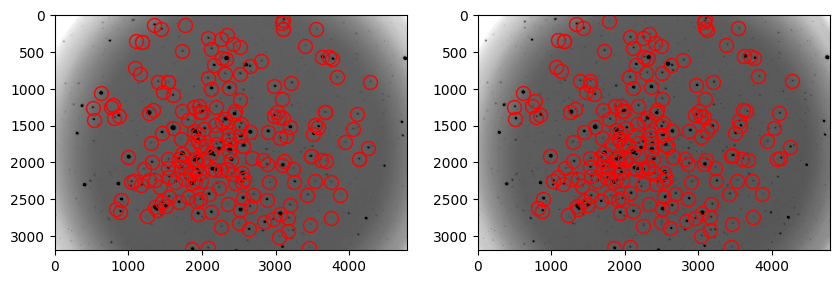

In [34]:
band1 = 'B'
band2 = 'G'
m36 = ["m36_003_G.fit", "m36_002_R.fit", "m36_004_B.fit"]
m38 = ["m38_003_G.fit", "m38_004_B.fit", "m38_002_R.fit"]

files = m36
image_data = calculateFluxes(files)
image_data = distances_from_center(image_data)
c1, r1 = process_image(image_data, band1, band2)

m38_003_G.fit
Processing file G
Estimated background sigma: 23.672560896841368
m38_004_B.fit
Processing file B
Estimated background sigma: 25.02304248244754
m38_002_R.fit
Processing file R
Estimated background sigma: 44.34593475937085
    xcentroid     
------------------
2867.8809831384356
2867.0914025462157
2210.6071021245675
1643.9568337368746
2392.4134691891268
1516.8002494183943
1617.0188383775658
 2743.138218179557
1502.3110039585495
1491.1868514952655
               ...
 2240.179247957033
1590.8452640844657
1664.0930998786412
 1615.731265041243
1550.4349156610967
2002.2986912831598
1834.8620763450326
 2176.201261043233
 2867.726921685347
1619.2590436373214
 2866.540614016908
Length = 423 rows
    xcentroid     
------------------
2867.8725446248695
2867.0787991083453
2347.0337479830487
2117.5571993698018
1616.5309915119979
1727.6665169803257
1538.3866034531131
 2741.500805121574
1486.5830286547402
1475.7221996097746
               ...
1708.0468747919763
1630.4598158346976
1780.1

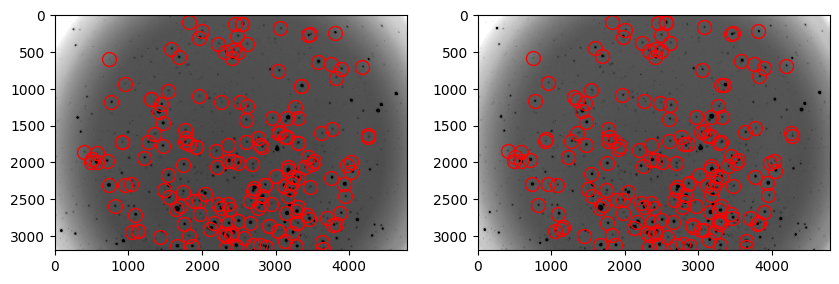

In [35]:
files = m38
image_data = calculateFluxes(files)
image_data = distances_from_center(image_data)
c2, r2 = process_image(image_data, band1, band2)

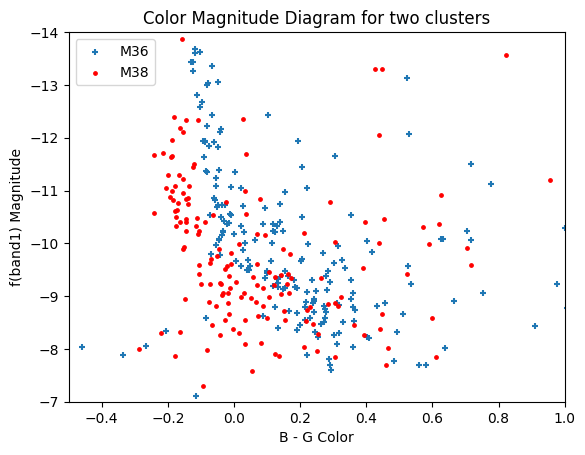

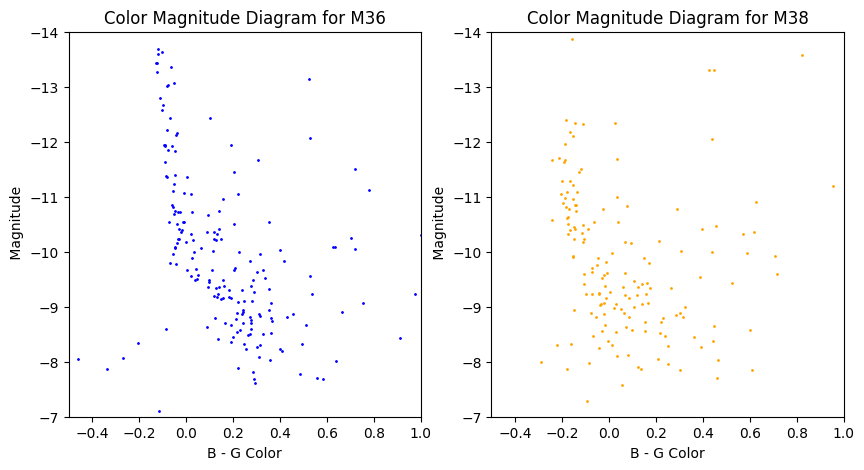

In [36]:


# plot the R magnitude against the R/B flux ratio
plt.scatter(c1, r1, s=16, label='M36', marker='+')

# use a small point size
plt.scatter(c2, r2, s=6, label='M38', marker='o', color='red')

plt.xlim(-0.5, 1.0)
plt.ylim(-7, -14)
plt.xlabel('B - G Color')
plt.ylabel('f(band1) Magnitude')

plt.legend()
plt.title('Color Magnitude Diagram for two clusters')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(c1, r1, s=1, label='M36', color='blue')
ax[1].scatter(c2, r2, s=1, label='M38', color='orange')

ax[0].set_ylim(-7, -14)
ax[1].set_ylim(-7, -14)

ax[0].set_xlim(-0.5, 1.0)
ax[1].set_xlim(-0.5, 1.0)

ax[0].set_title('Color Magnitude Diagram for M36')
ax[1].set_title('Color Magnitude Diagram for M38')

ax[0].set_xlabel('B - G Color')
ax[0].set_ylabel(' Magnitude')

ax[1].set_xlabel('B - G Color')
ax[1].set_ylabel(' Magnitude')

plt.show()
